# 1. Transformer와 비교해 변경이 필요한 부분
1. Positional encoding 대신 Position embedding을 사용한다
    - PositionalEncoding 블록을 없애고, gpt 블록 내에서 Position embedding을 추가한다
2. Question Answering task에 맞게 input transformation을 수행해주어야 한다
    - tokenize_and_filter 블록에서 디코더 입력과 출력 시퀀스를 구조에 맞추어 변경한다
    - 시작 토큰, 구분 토큰, 종료 토큰을 적절히 활용한다
3. 디코더만 사용한다
    - encoder_layer, encoder 블록을 없앤다
    - 디코더 블록 내에서 인코더 입력이 사용되는 부분을 변경한다
4. 디코더 레이어의 어텐션에서 Masked Multi Self Attention만 사용한다
    - decoder_layer 블록에서 인코더-디코더 부분을 없앤다
5. pre-training, fine-tuning 두 단계에 걸쳐 학습한다
    - pre-training을 위한 데이터셋, 모델을 구성하고 논문에 맞추어 컴파일, 학습한다
    - fine-tuning을 위한 데이터셋을 구성하고 논문에 맟추어 컴파일, 학습한다   
    
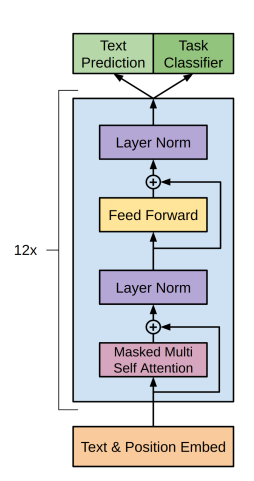

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## 모델링

### ~~포지셔널 인코딩~~
**사용하지 않음 [변경 1]**

In [ ]:
# 포지셔널 인코딩 레이어
'''
class PositionalEncoding(tf.keras.layers.Layer):
    def __init__(self, position, d_model):
        super(PositionalEncoding, self).__init__()
        self.pos_encoding = self.positional_encoding(position, d_model)
    # 포지셔널 인코딩 행렬을 만들기 위해 sin, cos 함수에 들어갈 값
    def get_angles(self, position, i, d_model):
        angles = 1 / tf.pow(10000, (2 * (i // 2)) / tf.cast(d_model, tf.float32))
        return position * angles

    def positional_encoding(self, position, d_model):
        # 각도 배열 생성
        # position: 행 인덱스, i: 열 인덱스
        angle_rads = self.get_angles(
            position=tf.range(position, dtype=tf.float32)[:, tf.newaxis],
            i=tf.range(d_model, dtype=tf.float32)[tf.newaxis, :],
            d_model=d_model)

        # 배열의 짝수 인덱스에는 sin 함수 적용
        sines = tf.math.sin(angle_rads[:, 0::2])
        # 배열의 홀수 인덱스에는 cosine 함수 적용
        cosines = tf.math.cos(angle_rads[:, 1::2])

        # sin과 cosine이 교차되도록 재배열
        pos_encoding = tf.stack([sines, cosines], axis=0)
        pos_encoding = tf.transpose(pos_encoding,[1, 2, 0]) 
        pos_encoding = tf.reshape(pos_encoding, [position, d_model])

        pos_encoding = pos_encoding[tf.newaxis, ...]
        return tf.cast(pos_encoding, tf.float32)
    # 문장 벡터 행렬과 포지셔널 인코딩 행렬 더하기
    def call(self, inputs):
        return inputs + self.pos_encoding[:, :tf.shape(inputs)[1], :]
'''

In [ ]:
'''# 포지셔널 인코딩 시각화
# 임베딩 벡터의 차원이 512이고 최대 문장의 길이가 50인 텍스트를 입력으로 할 때
sample_pos_encoding = PositionalEncoding(50, 512)

plt.pcolormesh(sample_pos_encoding.pos_encoding.numpy()[0], cmap='RdBu')
plt.xlabel('Depth')
plt.xlim((0, 512))
plt.ylabel('Position')
plt.colorbar()
plt.show()'''

### Attention

**Scaled dot product attention**
$$Attention(Q,K,V)=softmax(\dfrac{QK^T}{√d_k})V$$

In [2]:
# 스케일드 닷 프로덕트 어텐션 함수
def scaled_dot_product_attention(query, key, value, mask):
    # 어텐션 가중치는 Q와 K^T의 닷 프로덕트
    matmul_qk = tf.matmul(query, key, transpose_b=True)

    # 가중치를 정규화
    # tf.cast: 텐서의 dtype 변경
    depth = tf.cast(tf.shape(key)[-1], tf.float32)
    logits = matmul_qk / tf.math.sqrt(depth)

    # 마스크 추가
    if mask is not None:
        logits += (mask * -1e9)

    # softmax적용
    attention_weights = tf.nn.softmax(logits, axis=-1)

    # 최종 어텐션은 가중치와 V의 닷 프로덕트
    output = tf.matmul(attention_weights, value)
    return output

> Q. 왜 마스킹에서 0 같은 값 안 쓰고 1에 -1e9를 곱한 값을 쓰지? -1e9(~-inf)가 값으로 들어가 있으면 마스킹 효과가 생기나?  
A. 입력 값이 매우 작으면 그 위치의 소프트맥스 확률은 거의 0이 되기 때문

**Multihead attention**

In [3]:
class MultiHeadAttention(tf.keras.layers.Layer):

    def __init__(self, d_model, num_heads, name="multi_head_attention"):
        super(MultiHeadAttention, self).__init__(name=name)
        self.num_heads = num_heads
        self.d_model = d_model
        # num_heads는 d_model의 약수여야 함
        assert d_model % self.num_heads == 0
        # deapth: 각 head 별 열 크기
        self.depth = d_model // self.num_heads

        self.query_dense = tf.keras.layers.Dense(units=d_model)
        self.key_dense = tf.keras.layers.Dense(units=d_model)
        self.value_dense = tf.keras.layers.Dense(units=d_model)

        self.dense = tf.keras.layers.Dense(units=d_model)
    # head 개수 만큼 q, k, v를 나누는 함수
    # (batch_size, num_heads, 문장 길이, d_model/num_heads)가 됨
    def split_heads(self, inputs, batch_size):
        inputs = tf.reshape(inputs, shape=(batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(inputs, perm=[0, 2, 1, 3])

    def call(self, inputs):
        query, key, value, mask = inputs['query'], inputs['key'], inputs['value'], inputs['mask']
        batch_size = tf.shape(query)[0]

        # Q, K, V에 각각 Dense를 적용합니다
        query = self.query_dense(query)
        key = self.key_dense(key)
        value = self.value_dense(value)

        # 병렬 연산을 위한 머리를 여러 개(=shape를 하나 더 늘림) 만듭니다
        query = self.split_heads(query, batch_size)
        key = self.split_heads(key, batch_size)
        value = self.split_heads(value, batch_size)

        # 스케일드 닷 프로덕트 어텐션 함수
        scaled_attention = scaled_dot_product_attention(query, key, value, mask)

        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])

        # 어텐션 연산 후에 각 결과를 다시 연결(concatenate)합니다
        concat_attention = tf.reshape(scaled_attention,
                                  (batch_size, -1, self.d_model))

        # 최종 결과에도 Dense를 한 번 더 적용합니다
        outputs = self.dense(concat_attention)

        return outputs

### Masking
**Padding masking**  
숫자 0의 위치를 반환하는 마스크 생성

In [4]:
# 정수 시퀀스를 입력으로 함
def create_padding_mask(x):
    mask = tf.cast(tf.math.equal(x, 0), tf.float32)
    # (batch_size, 1, 1, sequence length)
    return mask[:, tf.newaxis, tf.newaxis, :]

In [ ]:
print(create_padding_mask(tf.constant([[1, 2, 0, 3, 0], [0, 0, 0, 4, 5]])))

**Look ahead masking**

In [5]:
def create_look_ahead_mask(x):
    seq_len = tf.shape(x)[1]
    # tf.linalg.band_part(input, num_lower, num_upper)
    look_ahead_mask = 1 - tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0)
    # padding masking도 함께 적용
    padding_mask = create_padding_mask(x)
    return tf.maximum(look_ahead_mask, padding_mask)

In [ ]:
print(create_look_ahead_mask(tf.constant([[1, 0, 3, 4, 5]])))

### ~~Encoder~~
**인코더를 사용하지 않음 [변경 3]**

In [ ]:
'''# 인코더 레이어 하나를 함수로 구현.
# 이 하나의 레이어 안에는 두 개의 서브 레이어가 존재합니다.
def encoder_layer(units, d_model, num_heads, dropout, name="encoder_layer"):
    inputs = tf.keras.Input(shape=(None, d_model), name="inputs")

    # 패딩 마스크 사용
    padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

    # 첫 번째 서브 레이어 : 멀티 헤드 셀프 어텐션 수행 (인코더 셀프 어텐션)
    attention = MultiHeadAttention(
        d_model, num_heads, name="attention")({
            'query': inputs,
            'key': inputs,
            'value': inputs,
            'mask': padding_mask
        })

    # 어텐션의 결과는 Dropout과 Layer Normalization이라는 훈련을 돕는 테크닉을 수행
    attention = tf.keras.layers.Dropout(rate=dropout)(attention)
    # 인풋과 어텐션 결과 residual connection
    attention = tf.keras.layers.LayerNormalization(
                                epsilon=1e-6)(inputs + attention)

    # 두 번째 서브 레이어 : 2개의 완전연결층
    outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention)
    outputs = tf.keras.layers.Dense(units=d_model)(outputs)

    # 완전연결층의 결과는 Dropout과 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
    outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
    # 어텐션 결과와 완전연결층 결과 residual connection
    outputs = tf.keras.layers.LayerNormalization(
                              epsilon=1e-6)(attention + outputs)

    return tf.keras.Model(
        inputs=[inputs, padding_mask], outputs=outputs, name=name)'''

> Q. 패딩 마스크는 정수 인코딩에 적용되는 거 아닌가? 여기서는 이미 임베딩을 거친 문장 벡터일텐데 패딩 마스크 쓰는 게 맞나?  
A. 패딩 마스크 자체는 정수 인코딩 된 것 기준으로 만들어졌으니 그것을 계속 쓰는 것

> Q. dropout 쓰라고 논문에 나와있나?  
A. **Residual Dropout** We apply dropout [27] to the output of each sub-layer, before it is added to the
sub-layer input and normalized. In addition, we apply dropout to the sums of the embeddings and the
positional encodings in both the encoder and decoder stacks. For the base model, we use a rate of
Pdrop = 0.1.


In [ ]:
'''# 여러 개의 인코더 레이어를 쌓아서 인코더를 만드는 encoder() 함수 구현
def encoder(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            name="encoder"):
    inputs = tf.keras.Input(shape=(None,), name="inputs")

    # 패딩 마스크 사용
    padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

    # 임베딩 레이어
    embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
    embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))

    # 포지셔널 인코딩
    embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

    outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

    # num_layers만큼 쌓아올린 인코더의 층.
    for i in range(num_layers):
        outputs = encoder_layer(
            units=units,
            d_model=d_model,
            num_heads=num_heads,
            dropout=dropout,
            name="encoder_layer_{}".format(i),
        )([outputs, padding_mask])

    return tf.keras.Model(
        inputs=[inputs, padding_mask], outputs=outputs, name=name)'''

> Q. 임베딩 레이어 거치고 d_model의 제곱근은 왜 곱해주는 거지?  
A. 논문에 나와있음: In the embedding layers, we multiply those weights by √
d_model

### Decoder
**디코더 레이어 구조 변경 [변경 4]**
- 인코더-디코더 어텐션 삭제
- activation Gaussian Error Linear Unit로 변경
> For the activation function, we used the Gaussian Error Linear Unit (GELU) [18].

In [6]:
# 디코더 레이어 하나를 함수로 구현.
# 이 하나의 레이어 안에는 두 개의 서브 레이어가 존재합니다.
def decoder_layer(units, d_model, num_heads, dropout, name="decoder_layer"):
    inputs = tf.keras.Input(shape=(None, d_model), name="inputs")
    '''    
    # 인코더 출력
    enc_outputs = tf.keras.Input(shape=(None, d_model), name="encoder_outputs")
    '''
    # 마스크드 디코더 멀티 헤드 어텐션 수행을 위한 마스크
    look_ahead_mask = tf.keras.Input(shape=(1, None, None), name="look_ahead_mask")
    '''
    # 패딩 마스크
    padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')
    '''
    
    # 첫 번째 서브 레이어 : 마스크드 멀티 헤드 셀프 어텐션 수행 (디코더 셀프 어텐션)
    attention1 = MultiHeadAttention(
        d_model, num_heads, name="attention_1")(inputs={
            'query': inputs,
            'key': inputs,
            'value': inputs,
            'mask': look_ahead_mask
        })

    # 멀티 헤드 어텐션의 결과는 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
    attention1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)(attention1 + inputs)

    '''    
    # 두 번째 서브 레이어 : 멀티 헤드 어텐션 수행 (인코더-디코더 어텐션)
    attention2 = MultiHeadAttention(
        d_model, num_heads, name="attention_2")(inputs={
            'query': attention1,
            'key': enc_outputs,
            'value': enc_outputs,
            'mask': padding_mask
        })

    # 마스크드 멀티 헤드 어텐션의 결과는
    # Dropout과 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
    attention2 = tf.keras.layers.Dropout(rate=dropout)(attention2)
    attention2 = tf.keras.layers.LayerNormalization(
        epsilon=1e-6)(attention2 + attention1)
    '''
    # 두 번째 서브 레이어 : 2개의 완전연결층
    '''
    outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention2)
    '''
    outputs = tf.keras.layers.Dense(units=units, activation='gelu')(attention1)
    outputs = tf.keras.layers.Dense(units=d_model)(outputs)
    # 완전연결층의 결과는 Dropout과 LayerNormalization 수행
    outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
    outputs = tf.keras.layers.LayerNormalization(epsilon=1e-6)(outputs + attention1)

    '''
    return tf.keras.Model(
        inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
        outputs=outputs,
        name=name)
    '''
    return tf.keras.Model(inputs=[inputs, look_ahead_mask], outputs=outputs, name=name)

**포지셔녈 인코딩 포지션 임베딩으로 변경 [변경 1]**

In [7]:
# 디코더 레이어 결합 및 gpt 구조 구현
def gpt(vocab_size,
        maxlen,
        num_layers,
        units,
        d_model,
        num_heads,
        dropout,
        name='gpt'):
    inputs = tf.keras.Input(shape=(None,), name='inputs')
    '''
    enc_outputs = tf.keras.Input(shape=(None, d_model), name='encoder_outputs')
    # 룩어헤드 마스크
    look_ahead_mask = tf.keras.Input(shape=(1, None, None), name='look_ahead_mask')
    # 패딩 마스크
    padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')
    '''
    # 마스크드 디코더 어텐션에서 사용되는 마스킹
    # 내부적으로 패딩 마스크도 포함됨
    look_ahead_mask = tf.keras.layers.Lambda(create_look_ahead_mask, output_shape=(1, None, None), name='look_ahead_mask')(inputs)
    
    # 임베딩 레이어
    embeddings = tf.keras.layers.Embedding(vocab_size, d_model, name='embedding')(inputs)
    embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))

    '''변경됨'''
    # 포지션 임베딩
    positions = tf.range(start=0, limit=maxlen)
    positions = tf.keras.layers.Embedding(maxlen, d_model)(positions)
    embeddings = embeddings + positions
    ''''''
    
    # Dropout이라는 훈련을 돕는 테크닉을 수행
    outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)
    '''
    # num_layers만큼 디코딩 층 쌓음
    for i in range(num_layers):
        outputs = decoder_layer(
            units=units,
            d_model=d_model,
            num_heads=num_heads,
            dropout=dropout,
            name='decoder_layer_{}'.format(i),
    )(inputs=[outputs, enc_outputs, look_ahead_mask, padding_mask])

    return tf.keras.Model(
        inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
        outputs=outputs,
        name=name)
    '''
    # num_layers만큼 디코딩 층 쌓음
    for i in range(num_layers):
        outputs = decoder_layer(
            units=units,
            d_model=d_model,
            num_heads=num_heads,
            dropout=dropout,
            name='decoder_layer_{}'.format(i)
        )(inputs=[outputs, look_ahead_mask])

    # 완전연결층
    outputs = tf.keras.layers.Dense(units=vocab_size, name="outputs")(outputs)

    return tf.keras.Model(inputs=inputs, outputs=outputs, name=name)

## 데이터셋
[한국어 챗봇 데이터](https://github.com/songys/Chatbot_data/blob/master/ChatbotData.csv)

데이터셋 파일 경로 설정

In [8]:
path = "./data/ChatbotData .csv"
data = pd.read_csv(path)
data.shape

(11823, 3)

In [9]:
data.head()

,Q,A,label
0,12시 땡!,하루가 또 가네요.,0
1,1지망 학교 떨어졌어,위로해 드립니다.,0
2,3박4일 놀러가고 싶다,여행은 언제나 좋죠.,0
3,3박4일 정도 놀러가고 싶다,여행은 언제나 좋죠.,0
4,PPL 심하네,눈살이 찌푸려지죠.,0


In [10]:
data.iloc[[8548, 5685]]

,Q,A,label
8548,헤어지누여자친구 만나러가ㅠ,좋은 마무리가 되길 바랄게요,1
5685,그사람이 자꾸 꿈에 나와,다른 생각들을 해보세요.,1


맞춤법이 맞지 않는 문장도 있음 -> 맞춤법 교정 패키지가 필요할 수 있음

In [11]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11823 entries, 0 to 11822
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Q       11823 non-null  object
 1   A       11823 non-null  object
 2   label   11823 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 277.2+ KB


결측치 없음

### 전처리 및 데이터 로드

In [12]:
# 숫자 표기 방식 통일
def preprocess_number(sentence):
    preprocess_dict = {
        "0":  "영",
        "공":  "영",
        "1":  "일",
        "하나": "일",
        "2":  "이",
        "둘":  "이",
        "3":  "삼",
        "셋":  "삼",
        "4":  "사",
        "넷":  "사",
        "5": "오",
        "다섯":  "오",
        "6":  "육",
        "여섯": "육",
        "7":  "칠",
        "일곱": "칠",
        "8":  "팔",
        "여덟": "팔",
        "9":  "구",
        "아홉": "구",
    }
    
    for key, value in preprocess_dict.items():
        if key in sentence:
            sentence = sentence.replace(key, value)

    return sentence

In [13]:
# 전처리 함수
def preprocess_sentence(sentence):
    # 단어와 구두점(punctuation) 사이의 거리를 만듭니다.
    # 토크나이징 하는 과정에서 구두점과 붙어있던 단어들을 하나의 단어로 인식하는 것을 방지
    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    sentence = re.sub(r'[" "]+', " ", sentence)
    
    # 숫자 표기 방식 통일
    sentence = preprocess_number(sentence)
    
    # (ㄱ-ㅎ, ㅏ-ㅣ, ".", "?", "!", ",")를 제외한 모든 문자를 공백인 ' '로 대체합니다.
    sentence = re.sub("[^ㄱ-ㅣ가-힣.?!,]", " ", sentence)
    
    # 양쪽 공백 제거
    sentence = sentence.strip()
    return sentence

In [14]:
preprocess_sentence("감aBㅇㅣ.!%,일23넷오여섯 ")

'감  ㅇㅣ . !   , 일이삼사오육'

In [15]:
# 질문과 답변의 쌍인 데이터셋을 구성하기 위한 데이터 로드 함수
# 전처리 함께 수행
def load_conversations(data):
    questions, answers = [], []
    
    for question in data['Q']:
        questions.append(preprocess_sentence(question))
                         
    for answer in data['A']:
        answers.append(preprocess_sentence(answer))
    return questions, answers

In [16]:
# 질문을 questions, 답변을 answers에 저장
questions, answers = load_conversations(data)
print('전체 샘플 수 :', len(questions))
print('전체 샘플 수 :', len(answers))

전체 샘플 수 : 11823
전체 샘플 수 : 11823


In [17]:
print('전처리 후의 22번째 질문 샘플: {}'.format(questions[21]))
print('전처리 후의 22번째 답변 샘플: {}'.format(answers[21]))

전처리 후의 22번째 질문 샘플: 가스비 장난 아님
전처리 후의 22번째 답변 샘플: 다음 달에는 더 절약해봐요 .


### vocab 생성

**토큰화**  
논문에서는 BPE 사용
> We used a bytepair encoding (BPE) vocabulary

In [18]:
# 질문과 답변 데이터셋에 대해서 Vocabulary 생성
tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(questions + answers, target_vocab_size=2**13)

In [19]:
tokenizer.subwords[:20]

[' .',
 ' ?',
 '거예요',
 '수_',
 '게_',
 '너무_',
 '더_',
 '거_',
 '좋아하는_',
 '이_',
 '는_',
 ' . ',
 '을_',
 '잘_',
 '도_',
 '요',
 '고_',
 '것_',
 '많이_',
 '안_']

**정수 인코딩**

In [20]:
# 시작 토큰과 종료 토큰에 고유한 정수를 부여
START_TOKEN, END_TOKEN = [tokenizer.vocab_size], [tokenizer.vocab_size + 1]

print('START_TOKEN의 번호 :' ,[tokenizer.vocab_size])
print('END_TOKEN의 번호 :' ,[tokenizer.vocab_size + 1])

START_TOKEN의 번호 : [8165]
END_TOKEN의 번호 : [8166]


### pre-training dataset 생성
사전학습 모델은 비라벨링 데이터로 훈련하므로 questions와 answers 데이터를 합친 뒤 입출력 데이터 생성(둘 중 하나만 쓸 수도 있지만 unsupervise learning에서는 데이터가 많을수록 좋다는 점 활용)

In [21]:
# 기존 vocab 사이즈에 시작, 끝, "구분 토큰" 추가
VOCAB_SIZE = tokenizer.vocab_size + 3
print(VOCAB_SIZE)

8168


In [22]:
# 샘플의 최대 허용 길이 또는 패딩 후의 최종 길이
MAX_LENGTH = 40

# 정수 인코딩, 최대 길이를 초과하는 샘플 제거, 패딩
def tokenize_and_filter(inputs, outputs):
    '''변경됨'''
    # questions와 answers를 합쳐서 사용할 것이므로 리스트 하나만 필요
    tokenized_sentences = []
    ''''''
    for (sentence1, sentence2) in zip(inputs, outputs):
        # tokenizer.encode()로 각 단어를 정수로 변환
        # 정수 인코딩 과정에서 시작 토큰과 종료 토큰을 추가
        sentence1 = START_TOKEN + tokenizer.encode(sentence1) + END_TOKEN
        sentence2 = START_TOKEN + tokenizer.encode(sentence2) + END_TOKEN

        # 최대 길이 20 이하인 경우에만 데이터셋으로 허용
        '''변경됨'''
        # 하나의 리스트에 저장
        if len(sentence1) <= MAX_LENGTH and len(sentence2) <= MAX_LENGTH:
            tokenized_sentences.extend([sentence1, sentence2])
        ''''''
    # 최대 길이 40으로 모든 데이터셋을 패딩
    tokenized_sentences = tf.keras.preprocessing.sequence.pad_sequences(
    tokenized_sentences, maxlen=MAX_LENGTH, padding='post')
  
    return tokenized_sentences

In [23]:
tokenized_sentences = tokenize_and_filter(questions, answers)
print('단어장의 크기 :',(VOCAB_SIZE))
print('필터링 후의 샘플 개수: {}'.format(len(tokenized_sentences)))

단어장의 크기 : 8168
필터링 후의 샘플 개수: 23646


#### 입력 파이프라인 구성
tf.data.Dataset API 활용

In [24]:
BATCH_SIZE = 64
BUFFER_SIZE = 20000

# 디코더는 이전의 target을 다음의 input으로 사용
# 따라서 outputs에서는 START_TOKEN을 제거
dataset = tf.data.Dataset.from_tensor_slices((
    {
        # 입력
        'inputs': tokenized_sentences[:, :-1]
    },
    {
        # 출력
        'outputs': tokenized_sentences[:, 1:]
    },
))

dataset = dataset.cache()
dataset = dataset.shuffle(BUFFER_SIZE)
dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)

train, validation 데이터셋 나누기

In [25]:
val_rate=0.1
ds_size = len(tokenized_sentences)
    
train_size = int((1-val_rate) * ds_size)
val_size = int(val_rate * ds_size)
    
train_dataset = dataset.take(train_size)    
val_dataset = dataset.skip(train_size)

In [26]:
# validation dataset 개수 확인
val_dataset.cardinality().numpy()

2365

In [27]:
# 데이터셋에 배치 적용
train_dataset = train_dataset.batch(BATCH_SIZE)
val_dataset = val_dataset.batch(BATCH_SIZE)

### fine-tuning dataset 생성
**Task-specific input transformations transformation을 수행 [변경 2]**
- 현재 데이터셋은 하나의 질문에 대해 답변이 한 개. 하지만 논문에서의 Question Answering task의 데이터는 가능한 답변 여러 개를 가짐
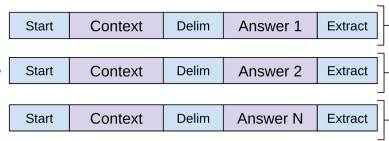
- 데이터셋 구성 과정은 사전학습 모델과 동일

In [28]:
# delimiter 토큰에 정수 부여
DELIMITER_TOKEN = [tokenizer.vocab_size+2]
print('DELIMITER_TOKEN의 번호 :' ,[tokenizer.vocab_size+2])

DELIMITER_TOKEN의 번호 : [8167]


In [32]:
# 정수 인코딩, 최대 길이를 초과하는 샘플 제거, 패딩
def tokenize_and_filter(inputs, outputs):
    tokenized_inputs, tokenized_outputs = [], []
    
    '''변경됨'''  
    for (sentence1, sentence2) in zip(inputs, outputs):
        # tokenizer.encode()로 각 단어를 정수로 변환
        # 정수 인코딩 과정에서 시작 토큰, 종료 토큰, 구분 토큰을 추가
        # sentence1(=input): 시작 토큰+질문+구분 토큰+답변+종료 토큰
        # sentence2(=output/label): 시작 토큰+답변+종료토큰
        sentence1 = START_TOKEN + tokenizer.encode(sentence1) + DELIMITER_TOKEN + tokenizer.encode(sentence2) + END_TOKEN
        sentence2 = START_TOKEN + tokenizer.encode(sentence2) + END_TOKEN
        ''''''

        # 입력과 출력 각각 40, 20 이하인 경우에만 데이터셋으로 허용
        if len(sentence1) <= MAX_LENGTH and len(sentence2) <= MAX_LENGTH:
            tokenized_inputs.append(sentence1)
            tokenized_outputs.append(sentence2)
            
    # 최대 길이 40으로 모든 데이터셋을 패딩
    tokenized_inputs = tf.keras.preprocessing.sequence.pad_sequences(
    tokenized_inputs, maxlen=MAX_LENGTH, padding='post')
    tokenized_outputs = tf.keras.preprocessing.sequence.pad_sequences(
    tokenized_outputs, maxlen=MAX_LENGTH, padding='post')
  
    return tokenized_inputs, tokenized_outputs

In [33]:
ft_inputs, outputs = tokenize_and_filter(questions, answers)
print('필터링 후의 질문 샘플 개수: {}'.format(len(ft_inputs)))
print('필터링 후의 답변 샘플 개수: {}'.format(len(outputs)))

필터링 후의 질문 샘플 개수: 11822
필터링 후의 답변 샘플 개수: 11822


#### 입력 파이프라인 구성
tf.data.Dataset API 활용  
- 파인튜닝 데이터셋은 배치사이즈 32로 진행
> For most tasks, we use a learning rate of 6.25e-5 and a batchsize of 32

In [34]:
'''
BATCH_SIZE = 64
'''
BATCH_SIZE = 32
BUFFER_SIZE = 20000

# 디코더는 이전의 target을 다음의 input으로 사용
# 따라서 outputs에서는 START_TOKEN을 제거
ft_dataset = tf.data.Dataset.from_tensor_slices((
    {
        # 입력
        'inputs': ft_inputs[:, :-1]
    },
    {
        # 레이블
        'outputs': outputs[:, 1:]
    },
))

ft_dataset = ft_dataset.cache()
ft_dataset = ft_dataset.shuffle(BUFFER_SIZE)
ft_dataset = ft_dataset.prefetch(tf.data.experimental.AUTOTUNE)

train, validation 데이터셋 나누기

In [35]:
val_rate=0.1
ds_size = len(ft_inputs)
    
train_size = int((1-val_rate) * ds_size)
val_size = int(val_rate * ds_size)
    
ft_train_dataset = ft_dataset.take(train_size)    
ft_val_dataset = ft_dataset.skip(train_size)

In [36]:
# validation dataset 개수 확인
ft_val_dataset.cardinality().numpy()

1183

In [37]:
# 데이터셋에 배치 적용
ft_train_dataset = ft_train_dataset.batch(BATCH_SIZE)
ft_val_dataset = ft_val_dataset.batch(BATCH_SIZE)

## 사전학습 모델 훈련

### 모델 생성

In [38]:
tf.keras.backend.clear_session()

# 하이퍼파라미터
NUM_LAYERS = 4 # 인코더와 디코더의 층의 개수(논문에서는 12)
D_MODEL = 256 # 인코더와 디코더 내부의 입, 출력의 고정 차원(논문에서는 768)
NUM_HEADS = 4 # 멀티 헤드 어텐션에서의 헤드 수(논문에서는 12)
UNITS = 1024 # 피드 포워드 신경망의 은닉층의 크기(논문에서는 3072)
DROPOUT = 0.1 # 드롭아웃의 비율

model = gpt(
    vocab_size=VOCAB_SIZE,
    maxlen=(MAX_LENGTH-1),
    num_layers=NUM_LAYERS,
    units=UNITS,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    dropout=DROPOUT)

model.summary()

Model: "gpt"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs (InputLayer)             [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, None, 256)    2091008     inputs[0][0]                     
__________________________________________________________________________________________________
tf.math.multiply (TFOpLambda)   (None, None, 256)    0           embedding[0][0]                  
__________________________________________________________________________________________________
tf.__operators__.add (TFOpLambd (None, 39, 256)      0           tf.math.multiply[0][0]           
________________________________________________________________________________________________

### 손실함수
레이블인 시퀀스에 패딩이 되어 있으므로, loss를 계산할 때 패딩 마스크를 적용해야 함

In [39]:
def loss_function(y_true, y_pred):
    y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
  
    loss = tf.keras.losses.SparseCategoricalCrossentropy(
        from_logits=True, reduction='none')(y_true, y_pred)

    mask = tf.cast(tf.not_equal(y_true, 0), tf.float32)
    loss = tf.multiply(loss, mask)

    return tf.reduce_mean(loss)

### 사용자 정의 학습률 스케쥴러
논문에 나온 설명을 참고하여 커스텀 학습률 스케줄러를 통한 아담 옵티마이저를 사용
> We used the Adam optimization scheme [27] with a max learning rate of 2.5e-4. The learning rate
was increased linearly from zero over the first 2000 updates and annealed to 0 using a cosine schedule

In [40]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):

    def __init__(self, d_model, warmup_steps=4000):
        super(CustomSchedule, self).__init__()

        self.d_model = d_model
        self.d_model = tf.cast(self.d_model, tf.float32)

        self.warmup_steps = warmup_steps
    
    def __call__(self, step):
        # 수식에서 min()의 첫번째 인자
        arg1 = tf.math.rsqrt(step)
        # 두번째 인자
        arg2 = step * (self.warmup_steps**-1.5)

        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

Text(0.5, 0, 'Train Step')

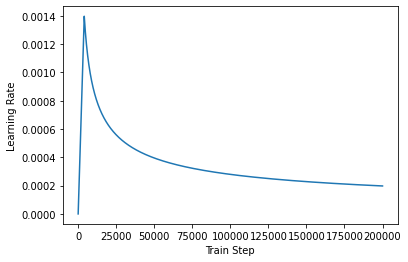

In [41]:
#  커스텀 학습률 스케줄링 계획을 시각화
sample_learning_rate = CustomSchedule(d_model=128)

plt.plot(sample_learning_rate(tf.range(200000, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")

### 모델 컴파일

In [42]:
learning_rate = CustomSchedule(D_MODEL)
# lr 스케쥴러를 사용하여 Adam optimizer 정의
optimizer = tf.keras.optimizers.Adam(
    learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

def accuracy(y_true, y_pred):
    y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
    return tf.keras.metrics.sparse_categorical_accuracy(y_true, y_pred)

model.compile(optimizer=optimizer, loss=loss_function, metrics=[accuracy])

### 모델 학습

In [44]:
EPOCHS = 2 # 논문에서는 100
history = model.fit(train_dataset,
                    epochs=EPOCHS,
                    validation_data=val_dataset)

Epoch 1/2
333/333 [==============================] - 20s 59ms/step - loss: 1.3481 - accuracy: 0.0253 - val_loss: 1.1414 - val_accuracy: 0.0358
Epoch 2/2
333/333 [==============================] - 19s 57ms/step - loss: 1.0906 - accuracy: 0.0375 - val_loss: 1.0159 - val_accuracy: 0.0398


결과 시각화

In [45]:
def plot_result(epochs, history):
    x = range(epochs)

    print(f"accuracy: {history.history['accuracy'][-1]: .3f}, validation accuracy: {history.history['val_accuracy'][-1]:.3f}")
    print(f"loss: {history.history['loss'][1]: .3f}, validation loss: {history.history['val_loss'][-1]:.3f}")

    plt.subplot(1,2,1)
    plt.plot(x, history.history['accuracy'], label='accuracy')
    plt.plot(x, history.history['val_accuracy'], label='validation accuracy')
    plt.legend()
    plt.subplot(1,2,2)
    plt.plot(x, history.history['loss'], label='loss')
    plt.plot(x, history.history['val_loss'], label='validation_loss')
    plt.legend()
    plt.show()

accuracy:  0.037, validation accuracy: 0.040
loss:  1.091, validation loss: 1.016


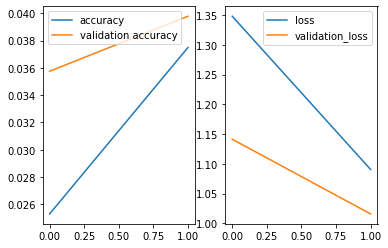

In [46]:
plot_result(EPOCHS, history)

```
# 하이퍼파라미터
NUM_LAYERS = 4 # 인코더와 디코더의 층의 개수(논문에서는 12)
D_MODEL = 256 # 인코더와 디코더 내부의 입, 출력의 고정 차원(논문에서는 768)
NUM_HEADS = 4 # 멀티 헤드 어텐션에서의 헤드 수(논문에서는 12)
UNITS = 1024 # 피드 포워드 신경망의 은닉층의 크기(논문에서는 3072)
DROPOUT = 0.1 # 드롭아웃의 비율
EPOCH = 30
```
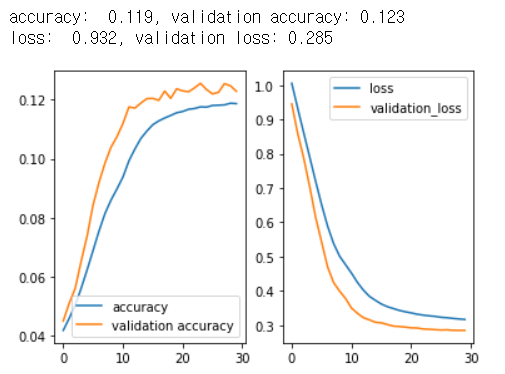

모델 가중치 저장

In [47]:
model.save_weights('pre_trained_weights.h5')

# fine-tuning

### fine-tuning 모델 생성

In [48]:
fine_tune_model = gpt(
    vocab_size=VOCAB_SIZE,
    maxlen=(MAX_LENGTH-1),
    num_layers=NUM_LAYERS,
    units=UNITS,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    dropout=DROPOUT
)

# pre-trained 모델로부터 가중치 불러오기
fine_tune_model.load_weights('pre_trained_weights.h5')

### 모델 컴파일
linear learning rate decay 스케쥴러 활용  
> We use a linear learning rate decay schedule with warmup over 0.2% of training. λ
was set to 0.5.

In [49]:
learning_rate = CustomSchedule(D_MODEL)
# lr 스케쥴러를 사용하여 Adam optimizer 정의
optimizer = tf.keras.optimizers.Adam(
    learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

def accuracy(y_true, y_pred):
    y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
    return tf.keras.metrics.sparse_categorical_accuracy(y_true, y_pred)

fine_tune_model.compile(optimizer=optimizer, loss=loss_function, metrics=[accuracy])

### 모델 학습 
>  Our model finetunes quickly and 3 epochs of training was sufficient
for most cases.

In [50]:
EPOCHS = 3
history = fine_tune_model.fit(ft_train_dataset,
                    epochs=EPOCHS,
                    validation_data=ft_val_dataset)

Epoch 1/3
333/333 [==============================] - 18s 41ms/step - loss: 1.0963 - accuracy: 0.0275 - val_loss: 1.0565 - val_accuracy: 0.0299
Epoch 2/3
333/333 [==============================] - 13s 39ms/step - loss: 1.0533 - accuracy: 0.0303 - val_loss: 1.0285 - val_accuracy: 0.0314
Epoch 3/3
333/333 [==============================] - 13s 39ms/step - loss: 1.0408 - accuracy: 0.0309 - val_loss: 1.0015 - val_accuracy: 0.0343


## 최종 모델 선택

In [51]:
final_model = fine_tune_model

# 추론

In [52]:
def decoder_inference(sentence):
    sentence = preprocess_sentence(sentence)

    # 입력된 문장을 정수 인코딩 후, 시작 토큰과 종료 토큰을 앞뒤로 추가.
    question = tf.constant(START_TOKEN + tokenizer.encode(sentence) + DELIMITER_TOKEN)
    question = tf.expand_dims(question, 0)
    answer = tf.expand_dims(DELIMITER_TOKEN, 0)
    # 디코더의 인퍼런스 단계
    for i in range(MAX_LENGTH):
        # 모델 입력 길이가 정해져 있어, 패딩을 추가함
        question = tf.keras.preprocessing.sequence.pad_sequences(
            question, maxlen=(MAX_LENGTH-1), padding='post')

        # 디코더는 최대 MAX_LENGTH의 길이만큼 다음 단어 예측을 반복합니다.
        predictions = model(inputs=question, training=False)
        predictions = predictions[:, -1:, :]
        # 현재 예측한 단어의 정수
        predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)
        # 만약 현재 예측한 단어가 종료 토큰이라면 for문을 종료
        if tf.equal(predicted_id, END_TOKEN[0]):
            break
        # 예측한 단어들은 지속적으로 question answer 추가됩니다.
        # question 다시 디코더의 입력이 됩니다.
        question = tf.concat([question, predicted_id], axis=-1)
        answer = tf.concat([answer, predicted_id], axis=-1)

    return tf.squeeze(answer, axis=0)

In [53]:
def sentence_generation(sentence):
  # 입력 문장에 대해서 디코더를 동작 시켜 예측된 정수 시퀀스를 리턴받습니다.
    prediction = decoder_inference(sentence)

  # 정수 시퀀스를 다시 텍스트 시퀀스로 변환합니다.
    predicted_sentence = tokenizer.decode(
        [i for i in prediction if i < tokenizer.vocab_size])

    print('입력 : {}'.format(sentence))
    print('출력 : {}'.format(predicted_sentence))

    return predicted_sentence

In [54]:
sentence_generation('그 사람')

입력 : 그 사람
출력 :   .


'  .'

In [55]:
sentence_generation("그사람이 자꾸")

입력 : 그사람이 자꾸
출력 : 


''